In [1]:
# Incident Occurred Predictor - avoiding data pollution
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import statsmodels.api as sm

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# 1) Read CSV
csv_path = "avalon_nuclear.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"{csv_path} not found in working directory.")
df = pd.read_csv(csv_path)
print("Loaded:", df.shape)
display(df.head())

# Check incident_occurred distribution
print("\n" + "="*70)
print("Target Variable Distribution: incident_occurred")
print("="*70)
print(df['incident_occurred'].value_counts())
print(f"\nIncident Rate: {df['incident_occurred'].mean():.4f}")

Loaded: (5000, 37)


,country,reactor_age_years,reactor_type_code,reactor_nominal_power_mw,load_factor_pct,population_within_30km,ambient_temp_c,co2_avoided_tons_per_hour,core_temp_c,coolant_pressure_bar,...,seismic_activity_index,cyber_attack_score,avalon_raw_risk_score,avalon_learned_reward_score,true_risk_level,avalon_evac_recommendation,avalon_shutdown_recommendation,human_override,incident_occurred,year
0,Hungary,23,4,756.331438,80.615726,1469895,14.216397,0.243889,281.072631,165.077514,...,0.161198,25.741555,1.115604,6.672804,3,1,1,0,0,2019
1,Croatia,32,4,1037.033725,91.116016,58077,5.261005,0.377962,288.553053,164.086104,...,2.893515,15.320646,2.649434,6.929254,3,1,1,0,0,2005
2,Norway,10,1,996.889393,85.375634,295678,19.442758,0.340440,316.605339,163.793783,...,6.042242,0.000000,1.340012,6.353381,3,0,1,0,0,1998
3,Belgium,10,2,1343.544270,83.479811,1354356,11.607403,0.448635,311.572273,145.419473,...,3.050245,18.325252,2.497715,6.684715,3,1,1,0,0,2011
4,Poland,36,4,1180.737140,100.000000,1048119,22.148477,0.472295,293.877648,158.847971,...,7.251403,8.235052,1.204937,6.041739,3,0,1,0,0,2009



Target Variable Distribution: incident_occurred
incident_occurred
0    4341
1     659
Name: count, dtype: int64

Incident Rate: 0.1318


/var/folders/sz/wh59dnjs4p1_q_6lrs1m0sg40000gn/T/ipykernel_85667/2786156209.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette=colors, ax=ax,


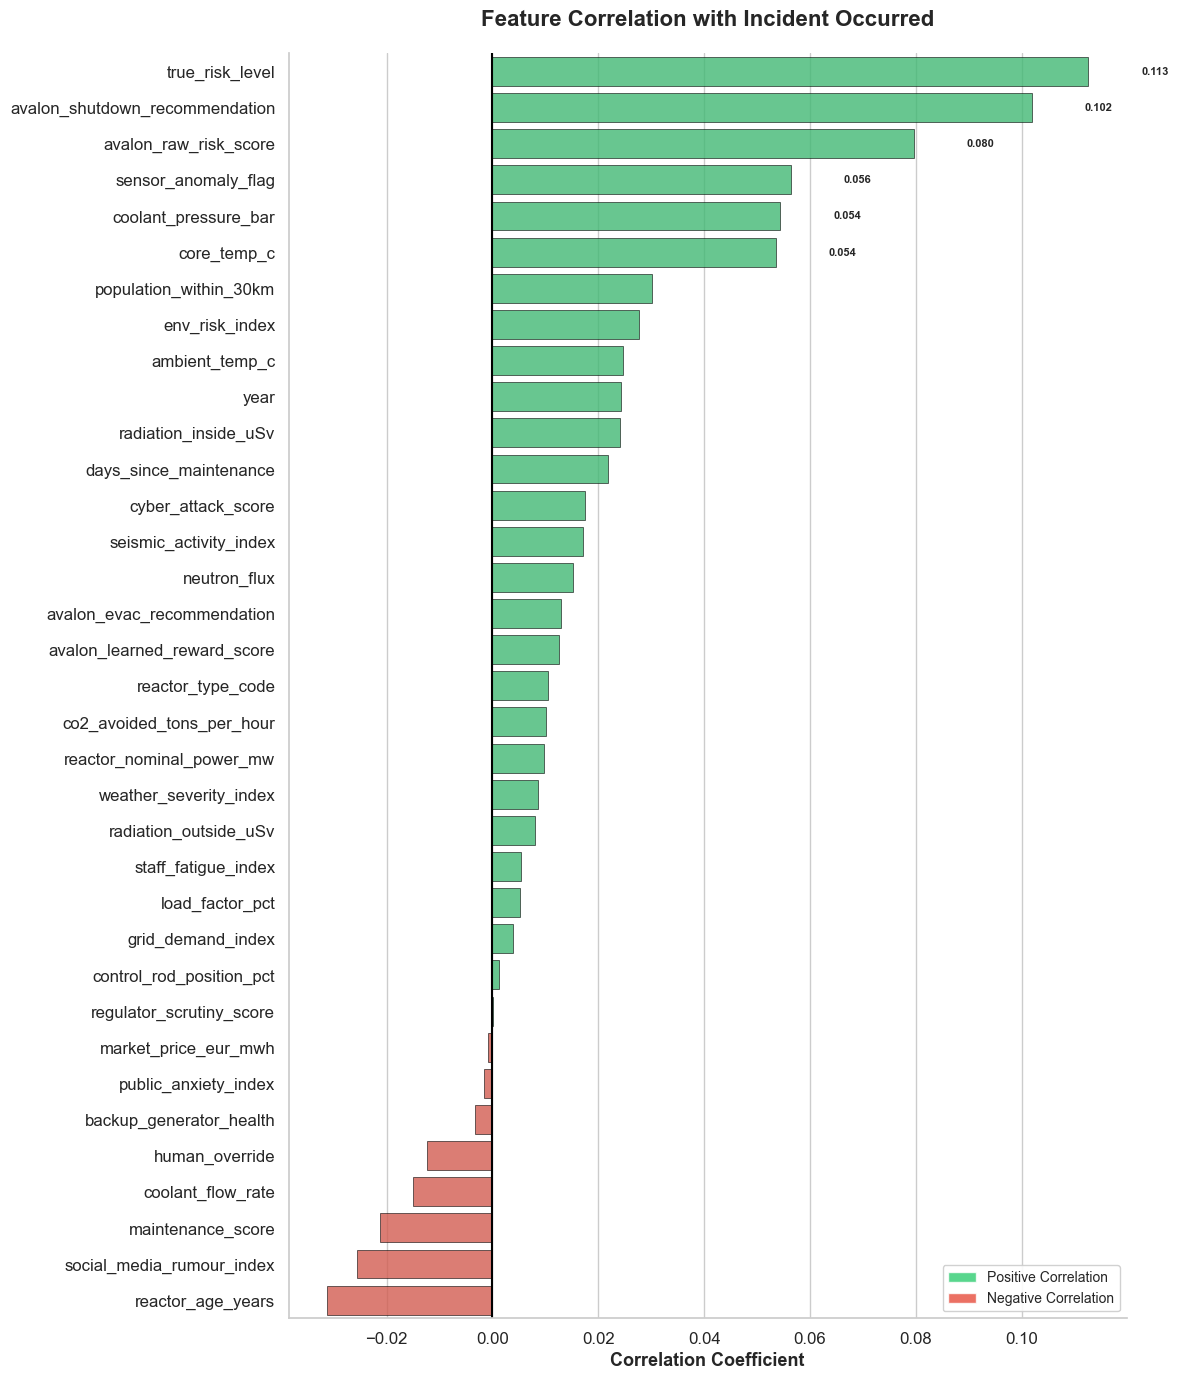


TOP 10 POSITIVE CORRELATIONS WITH INCIDENT_OCCURRED
true_risk_level                   0.112649
avalon_shutdown_recommendation    0.101925
avalon_raw_risk_score             0.079640
sensor_anomaly_flag               0.056374
coolant_pressure_bar              0.054373
core_temp_c                       0.053585
population_within_30km            0.030212
env_risk_index                    0.027621
ambient_temp_c                    0.024609
year                              0.024373
Name: incident_occurred, dtype: float64

TOP 10 NEGATIVE CORRELATIONS WITH INCIDENT_OCCURRED
control_rod_position_pct     0.001242
regulator_scrutiny_score     0.000200
market_price_eur_mwh        -0.000923
public_anxiety_index        -0.001562
backup_generator_health     -0.003369
human_override              -0.012327
coolant_flow_rate           -0.014995
maintenance_score           -0.021245
social_media_rumour_index   -0.025587
reactor_age_years           -0.031330
Name: incident_occurred, dtype: float64


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for beautiful plots
sns.set_theme(style="whitegrid", palette="husl")
sns.set_context("notebook", font_scale=1.1)

# Select only numerical columns for correlation analysis
numerical_df = df.select_dtypes(include=[np.number])

# Calculate correlations with incident_occurred
correlations = numerical_df.corr()['incident_occurred'].sort_values(ascending=False)

# Remove incident_occurred itself from the list
correlations = correlations.drop('incident_occurred')

# Create a beautiful horizontal bar plot using seaborn
plt.close('all')  # Close previous figures to prevent lag
fig, ax = plt.subplots(figsize=(12, 14))

# Create color palette
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in correlations.values]

# Use seaborn barplot
sns.barplot(x=correlations.values, y=correlations.index, palette=colors, ax=ax, 
            edgecolor='black', linewidth=0.5, alpha=0.8)

ax.set_xlabel('Correlation Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('')
ax.set_title('Feature Correlation with Incident Occurred', fontsize=16, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
sns.despine(top=True, right=True)

# Add value labels on bars
for i, val in enumerate(correlations.values):
    if abs(val) > 0.05:  # Only label significant correlations
        ax.text(val + (0.01 if val > 0 else -0.01), i, f'{val:.3f}', 
                va='center', ha='left' if val > 0 else 'right', fontsize=8, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', alpha=0.8, label='Positive Correlation'),
                   Patch(facecolor='#e74c3c', alpha=0.8, label='Negative Correlation')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()

# Print top correlations
print("\n" + "="*60)
print("TOP 10 POSITIVE CORRELATIONS WITH INCIDENT_OCCURRED")
print("="*60)
print(correlations.head(10))
print("\n" + "="*60)
print("TOP 10 NEGATIVE CORRELATIONS WITH INCIDENT_OCCURRED")
print("="*60)
print(correlations.tail(10))

In [4]:
# Prepare data for modeling: 60% train, 20% validation, 20% test split
# CRITICAL: Drop avalon_shutdown_recommendation, avalon_evac_recommendation and true_risk_level to avoid data pollution

print("\n" + "="*70)
print("🚨 DROPPING COLUMNS TO PREVENT DATA POLLUTION 🚨")
print("="*70)
print("Dropping: avalon_shutdown_recommendation, avalon_evac_recommendation, true_risk_level")
print("Reason: These are derived/target variables that would leak information")
print("="*70)

# Separate features and target
columns_to_drop = ['incident_occurred', 'avalon_shutdown_recommendation', 'avalon_evac_recommendation', 'true_risk_level']
X = df.drop(columns_to_drop, axis=1)
y = df['incident_occurred']

print(f"\nOriginal features: {df.shape[1]}")
print(f"Features after dropping pollution columns: {X.shape[1]}")
print(f"\nRemaining features: {list(X.columns)}")

# Handle categorical variables (country) - encode it
le = LabelEncoder()
X_processed = X.copy()
if 'country' in X_processed.columns:
    X_processed['country'] = le.fit_transform(X_processed['country'])

# First split: 60% train, 40% temp (which will be split into 20% val, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_processed, y, test_size=0.4, random_state=42, stratify=y
)

# Second split: split the 40% into 50-50 (20% val, 20% test of original)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTraining set size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")
print(f"\nTarget distribution in training set:")
print(y_train.value_counts().sort_index())

# Try different normalization techniques
print("\n" + "="*70)
print("     🔬 FEATURE NORMALIZATION COMPARISON 🔬")
print("="*70)

# 1. Standard Scaler (Z-score normalization)
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_val_standard = scaler_standard.transform(X_val)
X_test_standard = scaler_standard.transform(X_test)

# 2. MinMax Scaler (scales to [0, 1])
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_val_minmax = scaler_minmax.transform(X_val)
X_test_minmax = scaler_minmax.transform(X_test)

# 3. Robust Scaler (uses median and IQR, robust to outliers)
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train)
X_val_robust = scaler_robust.transform(X_val)
X_test_robust = scaler_robust.transform(X_test)

# Store for backwards compatibility
X_train_scaled = X_train_standard
X_val_scaled = X_val_standard
X_test_scaled = X_test_standard

print("\n✅ Created three normalized versions:")
print("   1. StandardScaler (Z-score): Mean=0, Std=1")
print("   2. MinMaxScaler: Scaled to [0, 1]")
print("   3. RobustScaler: Median-centered, robust to outliers")


🚨 DROPPING COLUMNS TO PREVENT DATA POLLUTION 🚨
Dropping: avalon_shutdown_recommendation, avalon_evac_recommendation, true_risk_level
Reason: These are derived/target variables that would leak information

Original features: 37
Features after dropping pollution columns: 33

Remaining features: ['country', 'reactor_age_years', 'reactor_type_code', 'reactor_nominal_power_mw', 'load_factor_pct', 'population_within_30km', 'ambient_temp_c', 'co2_avoided_tons_per_hour', 'core_temp_c', 'coolant_pressure_bar', 'neutron_flux', 'control_rod_position_pct', 'coolant_flow_rate', 'radiation_inside_uSv', 'radiation_outside_uSv', 'maintenance_score', 'days_since_maintenance', 'sensor_anomaly_flag', 'grid_demand_index', 'market_price_eur_mwh', 'backup_generator_health', 'staff_fatigue_index', 'public_anxiety_index', 'social_media_rumour_index', 'regulator_scrutiny_score', 'env_risk_index', 'weather_severity_index', 'seismic_activity_index', 'cyber_attack_score', 'avalon_raw_risk_score', 'avalon_learned

In [5]:
# Logistic Regression with Lasso (L1) regularization for binary classification
# Test different lambda (C) values - note: sklearn uses C = 1/lambda
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score

# Range of C values (inverse of lambda)
# Smaller C = stronger regularization (larger lambda)
C_values = np.logspace(-3, 3, 10)  # From 0.001 to 1000
lambdas = 1 / C_values  # Convert to lambda for interpretation

# Store coefficients for each C value
coefficients = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []
val_auc_scores = []

print("Training Lasso Logistic Regression models with varying regularization...")

for C in C_values:
    # Train logistic regression with L1 penalty (Lasso)
    model = LogisticRegression(
        penalty='l1',
        C=C,
        solver='saga',  # saga solver supports L1 penalty
        max_iter=2000,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    
    # Store coefficients
    coefficients.append(np.abs(model.coef_[0]))
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
    val_acc = accuracy_score(y_val, model.predict(X_val_scaled))
    val_f1 = f1_score(y_val, model.predict(X_val_scaled))
    
    # Get probability predictions for AUC
    val_probs = model.predict_proba(X_val_scaled)[:, 1]
    val_auc = roc_auc_score(y_val, val_probs)
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    val_auc_scores.append(val_auc)

print(f"Completed training {len(C_values)} models")

Training Lasso Logistic Regression models with varying regularization...
Completed training 10 models


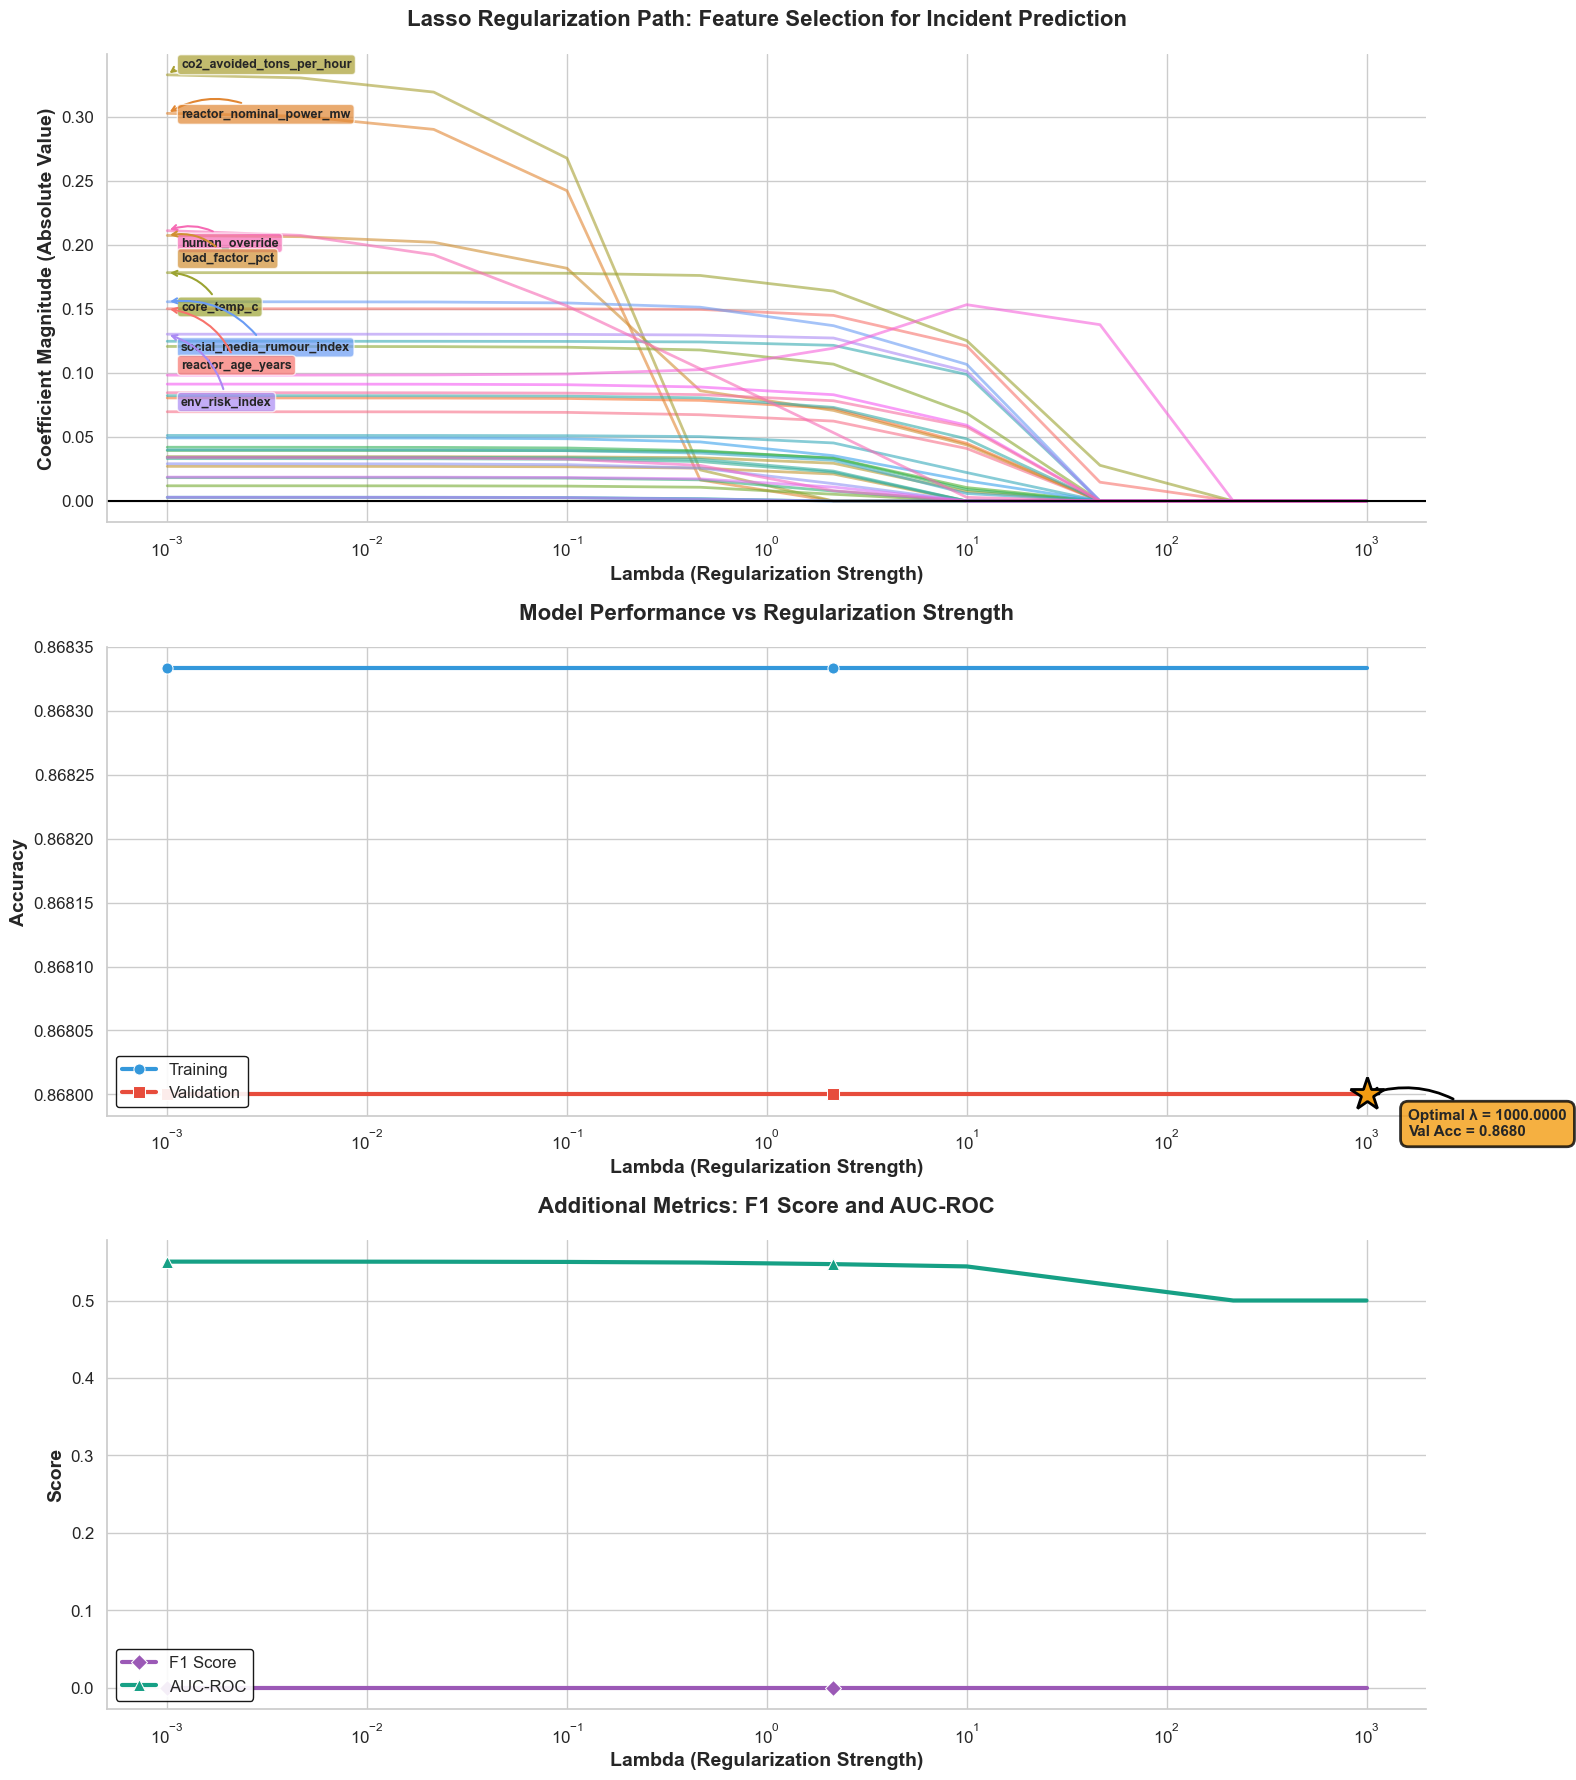


           🎯 OPTIMAL LASSO LOGISTIC REGRESSION MODEL 🎯

Best Validation Accuracy:      0.8680
Best Validation F1 Score:      0.0000
Best Validation AUC-ROC:       0.5000
Optimal Lambda:                1000.000000
Optimal C (1/Lambda):          0.001000
Training Accuracy:             0.8683

           🏆 TOP 10 MOST IMPORTANT FEATURES 🏆

Rank   Feature Name                        Coefficient Magnitude
----------------------------------------------------------------------
1      year                                0.0000              
2      maintenance_score                   0.0000              
3      reactor_age_years                   0.0000              
4      reactor_type_code                   0.0000              
5      reactor_nominal_power_mw            0.0000              
6      load_factor_pct                     0.0000              
7      population_within_30km              0.0000              
8      ambient_temp_c                      0.0000              
9      co2_a

In [6]:
# Visualize the regularization path and model performance
plt.close('all')  # Close previous figures to prevent lag

coefficients_array = np.array(coefficients)
feature_names = X_train.columns

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 18))

# Plot 1: Coefficient paths as lambda increases using seaborn
ax1 = axes[0]

# Prepare data for seaborn lineplot
coef_df = pd.DataFrame(coefficients_array, columns=feature_names)
coef_df['lambda'] = lambdas

# Melt for seaborn format
coef_melted = coef_df.melt(id_vars=['lambda'], var_name='Feature', value_name='Coefficient')

# Plot using seaborn
sns.lineplot(data=coef_melted, x='lambda', y='Coefficient', hue='Feature', 
             ax=ax1, linewidth=2, alpha=0.6, legend=False)

ax1.set_xscale('log')
ax1.set_xlabel('Lambda (Regularization Strength)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Coefficient Magnitude (Absolute Value)', fontsize=14, fontweight='bold')
ax1.set_title('Lasso Regularization Path: Feature Selection for Incident Prediction', 
              fontsize=16, fontweight='bold', pad=20)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
sns.despine(ax=ax1)

# Annotate top features at the end
final_coef_idx = np.argsort(coefficients_array[-1])[-8:][::-1]  # Top 8 features
colors_palette = sns.color_palette("husl", len(feature_names))
for rank, idx in enumerate(final_coef_idx):
    y_pos = coefficients_array[-1, idx]
    ax1.annotate(feature_names[idx], 
                xy=(lambdas[-1], y_pos),
                xytext=(10, 5 - rank*8),
                textcoords='offset points',
                fontsize=9,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=colors_palette[idx], alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', 
                              color=colors_palette[idx], linewidth=1.5))

# Plot 2: Model accuracy vs lambda
ax2 = axes[1]

# Prepare data for seaborn
accuracy_df = pd.DataFrame({
    'lambda': np.concatenate([lambdas, lambdas]),
    'Accuracy': np.concatenate([train_accuracies, val_accuracies]),
    'Dataset': ['Training']*len(lambdas) + ['Validation']*len(lambdas)
})

sns.lineplot(data=accuracy_df, x='lambda', y='Accuracy', hue='Dataset', 
             style='Dataset', markers=['o', 's'], dashes=False, 
             linewidth=3, markersize=8, markevery=5, ax=ax2,
             palette={'Training': '#3498db', 'Validation': '#e74c3c'})

ax2.set_xscale('log')
ax2.set_xlabel('Lambda (Regularization Strength)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax2.set_title('Model Performance vs Regularization Strength', fontsize=16, fontweight='bold', pad=20)
sns.despine(ax=ax2)

# Mark the best validation accuracy
best_idx = np.argmax(val_accuracies)
ax2.plot(lambdas[best_idx], val_accuracies[best_idx], marker='*', markersize=25, 
         color='#f39c12', markeredgecolor='black', markeredgewidth=2, zorder=10)

ax2.annotate(f'Optimal λ = {lambdas[best_idx]:.4f}\nVal Acc = {val_accuracies[best_idx]:.4f}',
            xy=(lambdas[best_idx], val_accuracies[best_idx]),
            xytext=(30, -30),
            textcoords='offset points',
            fontsize=11,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#f39c12', alpha=0.8, edgecolor='black', linewidth=2),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', 
                          color='black', linewidth=2))

ax2.legend(fontsize=12, loc='lower left', framealpha=0.9, edgecolor='black')

# Plot 3: F1 Score and AUC vs lambda
ax3 = axes[2]

metric_df = pd.DataFrame({
    'lambda': np.concatenate([lambdas, lambdas]),
    'Score': np.concatenate([val_f1_scores, val_auc_scores]),
    'Metric': ['F1 Score']*len(lambdas) + ['AUC-ROC']*len(lambdas)
})

sns.lineplot(data=metric_df, x='lambda', y='Score', hue='Metric', 
             style='Metric', markers=['D', '^'], dashes=False, 
             linewidth=3, markersize=8, markevery=5, ax=ax3,
             palette={'F1 Score': '#9b59b6', 'AUC-ROC': '#16a085'})

ax3.set_xscale('log')
ax3.set_xlabel('Lambda (Regularization Strength)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Score', fontsize=14, fontweight='bold')
ax3.set_title('Additional Metrics: F1 Score and AUC-ROC', fontsize=16, fontweight='bold', pad=20)
sns.despine(ax=ax3)
ax3.legend(fontsize=12, loc='lower left', framealpha=0.9, edgecolor='black')

plt.tight_layout()
plt.show()

# Print beautiful summary of best model
print("\n" + "="*70)
print("           🎯 OPTIMAL LASSO LOGISTIC REGRESSION MODEL 🎯")
print("="*70)
print(f"\n{'Best Validation Accuracy:':<30} {val_accuracies[best_idx]:.4f}")
print(f"{'Best Validation F1 Score:':<30} {val_f1_scores[best_idx]:.4f}")
print(f"{'Best Validation AUC-ROC:':<30} {val_auc_scores[best_idx]:.4f}")
print(f"{'Optimal Lambda:':<30} {lambdas[best_idx]:.6f}")
print(f"{'Optimal C (1/Lambda):':<30} {C_values[best_idx]:.6f}")
print(f"{'Training Accuracy:':<30} {train_accuracies[best_idx]:.4f}")

print("\n" + "="*70)
print("           🏆 TOP 10 MOST IMPORTANT FEATURES 🏆")
print("="*70)
best_coefs = coefficients_array[best_idx]
top_features_idx = np.argsort(best_coefs)[-10:][::-1]

print(f"\n{'Rank':<6} {'Feature Name':<35} {'Coefficient Magnitude':<20}")
print("-"*70)
for rank, idx in enumerate(top_features_idx, 1):
    print(f"{rank:<6} {feature_names[idx]:<35} {best_coefs[idx]:<20.4f}")
print("="*70)


     📊 FINAL LASSO LOGISTIC REGRESSION MODEL PERFORMANCE 📊

Dataset         Accuracy     F1 Score     AUC-ROC      Samples   
----------------------------------------------------------------------
Training        0.8683       0.0000       0.5000       3000      
Validation      0.8680       0.0000       0.5000       1000      
Test            0.8680       0.0000       0.5000       1000      

               📋 CLASSIFICATION REPORT (Test Set) 📋
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       868
           1       0.00      0.00      0.00       132

    accuracy                           0.87      1000
   macro avg       0.43      0.50      0.46      1000
weighted avg       0.75      0.87      0.81      1000



/Users/samuel/anaconda3/envs/DL/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/samuel/anaconda3/envs/DL/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/samuel/anaconda3/envs/DL/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

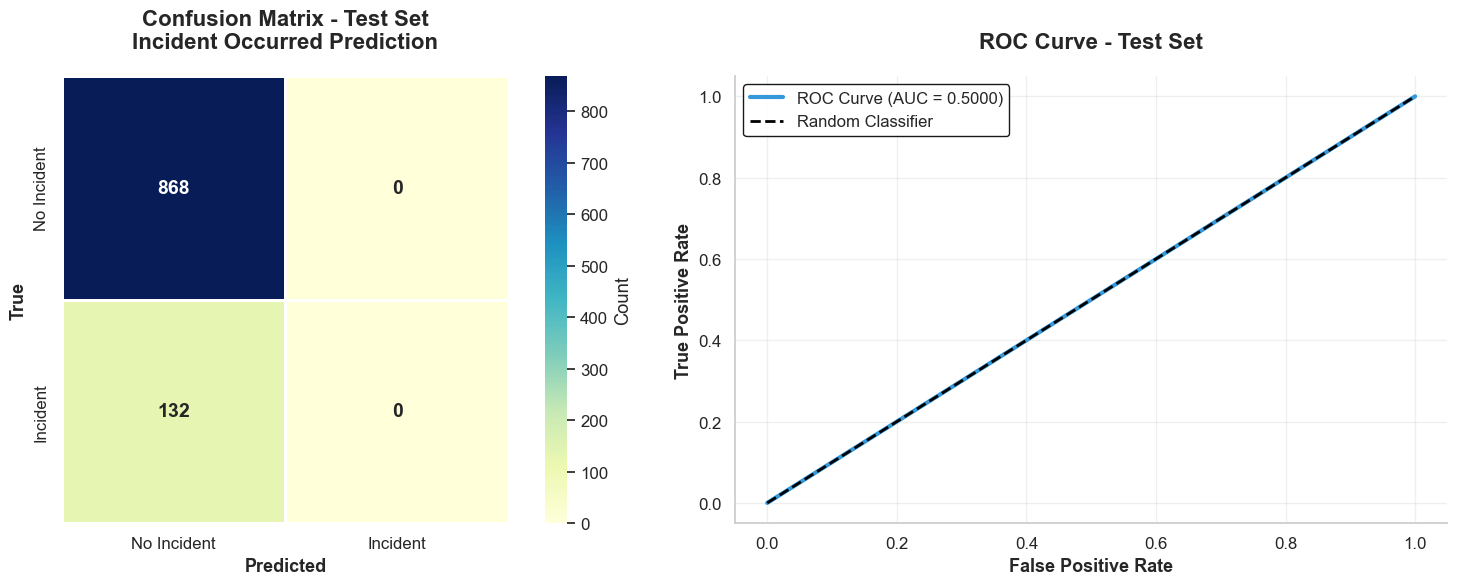

In [7]:
# Train final model with optimal hyperparameters and evaluate on test set
plt.close('all')  # Close previous figures to prevent lag

best_C = C_values[best_idx]

final_model = LogisticRegression(
    penalty='l1',
    C=best_C,
    solver='saga',
    max_iter=2000,
    random_state=42
)

final_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = final_model.predict(X_train_scaled)
y_val_pred = final_model.predict(X_val_scaled)
y_test_pred = final_model.predict(X_test_scaled)

# Get probabilities for AUC
y_train_probs = final_model.predict_proba(X_train_scaled)[:, 1]
y_val_probs = final_model.predict_proba(X_val_scaled)[:, 1]
y_test_probs = final_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n" + "="*70)
print("     📊 FINAL LASSO LOGISTIC REGRESSION MODEL PERFORMANCE 📊")
print("="*70)
print(f"\n{'Dataset':<15} {'Accuracy':<12} {'F1 Score':<12} {'AUC-ROC':<12} {'Samples':<10}")
print("-"*70)
print(f"{'Training':<15} {accuracy_score(y_train, y_train_pred):<12.4f} {f1_score(y_train, y_train_pred):<12.4f} {roc_auc_score(y_train, y_train_probs):<12.4f} {len(y_train):<10}")
print(f"{'Validation':<15} {accuracy_score(y_val, y_val_pred):<12.4f} {f1_score(y_val, y_val_pred):<12.4f} {roc_auc_score(y_val, y_val_probs):<12.4f} {len(y_val):<10}")
print(f"{'Test':<15} {accuracy_score(y_test, y_test_pred):<12.4f} {f1_score(y_test, y_test_pred):<12.4f} {roc_auc_score(y_test, y_test_probs):<12.4f} {len(y_test):<10}")
print("="*70)

print("\n" + "="*70)
print("               📋 CLASSIFICATION REPORT (Test Set) 📋")
print("="*70)
print(classification_report(y_test, y_test_pred))

# Beautiful confusion matrix using seaborn
from sklearn.metrics import confusion_matrix

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

cm = confusion_matrix(y_test, y_test_pred)

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'}, 
            linewidths=2, linecolor='white', square=True, ax=ax1,
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})

ax1.set_title('Confusion Matrix - Test Set\nIncident Occurred Prediction', 
             fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Predicted', fontsize=13, fontweight='bold')
ax1.set_ylabel('True', fontsize=13, fontweight='bold')
ax1.set_xticklabels(['No Incident', 'Incident'])
ax1.set_yticklabels(['No Incident', 'Incident'])

# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
test_auc = roc_auc_score(y_test, y_test_probs)

ax2.plot(fpr, tpr, linewidth=3, color='#3498db', label=f'ROC Curve (AUC = {test_auc:.4f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
ax2.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax2.set_title('ROC Curve - Test Set', fontsize=16, fontweight='bold', pad=20)
ax2.legend(fontsize=12, framealpha=0.9, edgecolor='black')
ax2.grid(True, alpha=0.3)
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()


     📊 NORMALIZATION TECHNIQUE COMPARISON 📊

StandardScaler:
  Train: 0.8683 | Val: 0.8680 | Test: 0.8680
  Test F1: 0.0000 | Test AUC: 0.5000

MinMaxScaler:
  Train: 0.8683 | Val: 0.8680 | Test: 0.8680
  Test F1: 0.0000 | Test AUC: 0.5000

RobustScaler:
  Train: 0.8683 | Val: 0.8680 | Test: 0.8680
  Test F1: 0.0000 | Test AUC: 0.5000


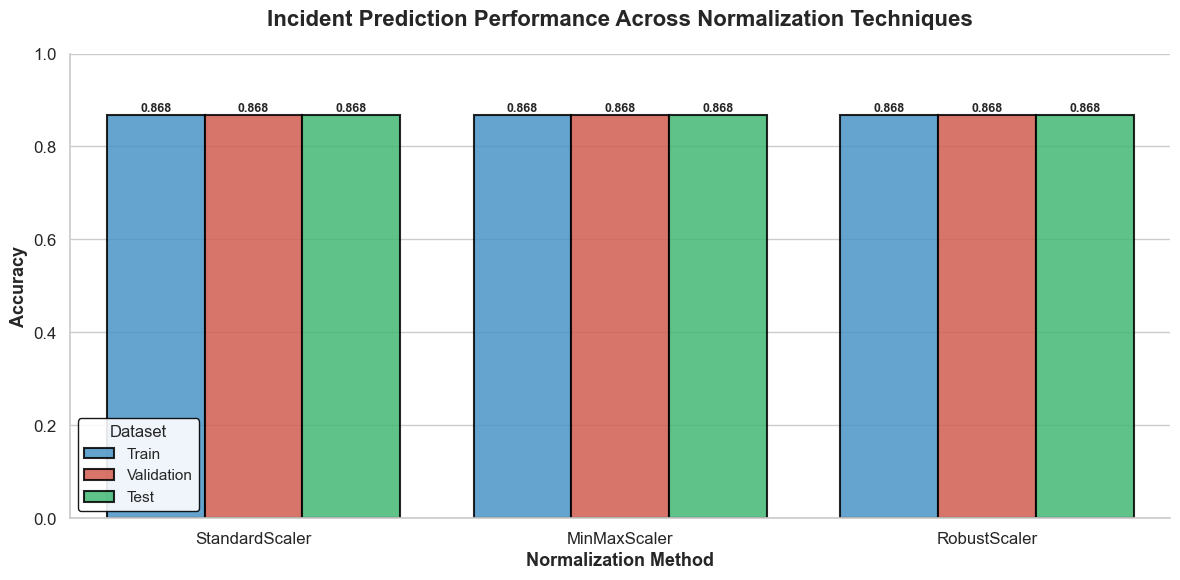


🏆 Best Normalization: StandardScaler (Test Acc: 0.8680)


In [8]:
# Compare normalization techniques on Logistic Regression
plt.close('all')

print("\n" + "="*70)
print("     📊 NORMALIZATION TECHNIQUE COMPARISON 📊")
print("="*70)

normalization_results = []

for scaler_name, X_tr, X_v, X_te in [
    ('StandardScaler', X_train_standard, X_val_standard, X_test_standard),
    ('MinMaxScaler', X_train_minmax, X_val_minmax, X_test_minmax),
    ('RobustScaler', X_train_robust, X_val_robust, X_test_robust)
]:
    # Train model with optimal C from previous analysis
    model = LogisticRegression(
        penalty='l1',
        C=best_C if 'best_C' in dir() else 1.0,
        solver='saga',
        max_iter=2000,
        random_state=42
    )
    model.fit(X_tr, y_train)
    
    # Evaluate
    train_acc = accuracy_score(y_train, model.predict(X_tr))
    val_acc = accuracy_score(y_val, model.predict(X_v))
    test_acc = accuracy_score(y_test, model.predict(X_te))
    
    test_f1 = f1_score(y_test, model.predict(X_te))
    test_auc = roc_auc_score(y_test, model.predict_proba(X_te)[:, 1])
    
    normalization_results.append({
        'Scaler': scaler_name,
        'Train': train_acc,
        'Validation': val_acc,
        'Test': test_acc,
        'Test F1': test_f1,
        'Test AUC': test_auc
    })
    
    print(f"\n{scaler_name}:")
    print(f"  Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")
    print(f"  Test F1: {test_f1:.4f} | Test AUC: {test_auc:.4f}")

# Create beautiful comparison plot
results_df = pd.DataFrame(normalization_results)
results_melted = results_df.melt(id_vars='Scaler', 
                                  value_vars=['Train', 'Validation', 'Test'],
                                  var_name='Dataset', value_name='Accuracy')

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=results_melted, x='Scaler', y='Accuracy', hue='Dataset', 
            palette={'Train': '#3498db', 'Validation': '#e74c3c', 'Test': '#2ecc71'},
            ax=ax, edgecolor='black', linewidth=1.5, alpha=0.85)

ax.set_title('Incident Prediction Performance Across Normalization Techniques', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Normalization Method', fontsize=13, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax.set_ylim([0, 1])
sns.despine()

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=9, fontweight='bold')

ax.legend(title='Dataset', fontsize=11, title_fontsize=12, framealpha=0.9, edgecolor='black')
plt.tight_layout()
plt.show()

# Identify best scaler
best_result = results_df.loc[results_df['Test'].idxmax()]
print(f"\n🏆 Best Normalization: {best_result['Scaler']} (Test Acc: {best_result['Test']:.4f})")
print("="*70)

In [ ]:
# SVM Analysis with Different Kernels
from sklearn.svm import SVC

print("\n" + "="*70)
print("     🤖 SUPPORT VECTOR MACHINE (SVM) ANALYSIS 🤖")
print("="*70)

# Define kernels to test
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
C_values_svm = np.logspace(-2, 2, 10)  # Regularization parameter

# Store results for each kernel
svm_results = {kernel: {'train': [], 'val': [], 'C_values': C_values_svm} for kernel in kernels}

print("\nTraining SVM models with different kernels...")
print("This may take a few minutes...\n")

for kernel in kernels:
    print(f"Training {kernel.upper()} kernel SVM...")
    for C in C_values_svm:
        # Use StandardScaler as it's typically best for SVM
        model = SVC(
            kernel=kernel,
            C=C,
            random_state=42,
            degree=3 if kernel == 'poly' else 3,  # degree only matters for poly
            gamma='scale'  # auto-adjust based on features
        )
        
        model.fit(X_train_standard, y_train)
        
        train_acc = accuracy_score(y_train, model.predict(X_train_standard))
        val_acc = accuracy_score(y_val, model.predict(X_val_standard))
        
        svm_results[kernel]['train'].append(train_acc)
        svm_results[kernel]['val'].append(val_acc)
    
    # Find best C for this kernel
    best_idx_kernel = np.argmax(svm_results[kernel]['val'])
    best_C_kernel = C_values_svm[best_idx_kernel]
    best_val_acc = svm_results[kernel]['val'][best_idx_kernel]
    
    print(f"  ✓ Best C: {best_C_kernel:.4f}, Val Acc: {best_val_acc:.4f}")

print("\n✅ Completed training all SVM models!")


     🤖 SUPPORT VECTOR MACHINE (SVM) ANALYSIS 🤖

Training SVM models with different kernels...
This may take a few minutes...

Training LINEAR kernel SVM...


In [ ]:
# Visualize SVM Performance Across Different Kernels
plt.close('all')

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

kernel_colors = {
    'linear': '#3498db',
    'rbf': '#e74c3c', 
    'poly': '#2ecc71',
    'sigmoid': '#f39c12'
}

# Plot each kernel in its own subplot
for idx, kernel in enumerate(kernels):
    ax = axes[idx]
    
    # Prepare data for seaborn
    kernel_df = pd.DataFrame({
        'C': np.concatenate([C_values_svm, C_values_svm]),
        'Accuracy': np.concatenate([svm_results[kernel]['train'], svm_results[kernel]['val']]),
        'Dataset': ['Training']*len(C_values_svm) + ['Validation']*len(C_values_svm)
    })
    
    # Plot using seaborn
    sns.lineplot(data=kernel_df, x='C', y='Accuracy', hue='Dataset', style='Dataset',
                markers=['o', 's'], dashes=False, linewidth=3, markersize=6, 
                markevery=3, ax=ax,
                palette={'Training': kernel_colors[kernel], 
                        'Validation': sns.light_palette(kernel_colors[kernel], n_colors=3)[0]})
    
    ax.set_xscale('log')
    ax.set_xlabel('C (Regularization Parameter)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title(f'{kernel.upper()} Kernel SVM - Incident Prediction', fontsize=14, fontweight='bold', pad=15)
    sns.despine(ax=ax)
    
    # Mark best validation point
    best_idx_k = np.argmax(svm_results[kernel]['val'])
    best_C_k = C_values_svm[best_idx_k]
    best_val_k = svm_results[kernel]['val'][best_idx_k]
    
    ax.plot(best_C_k, best_val_k, marker='*', markersize=20, 
            color='gold', markeredgecolor='black', markeredgewidth=2, zorder=10)
    
    ax.annotate(f'Best C={best_C_k:.3f}\nVal Acc={best_val_k:.4f}',
               xy=(best_C_k, best_val_k),
               xytext=(20, -20),
               textcoords='offset points',
               fontsize=10,
               fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.4', facecolor='gold', alpha=0.7, edgecolor='black', linewidth=1.5),
               arrowprops=dict(arrowstyle='->', color='black', linewidth=1.5))
    
    ax.legend(fontsize=10, framealpha=0.9, edgecolor='black')
    ax.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('SVM Performance Comparison for Incident Prediction', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("           📊 SVM KERNEL COMPARISON SUMMARY 📊")
print("="*70)
print(f"\n{'Kernel':<12} {'Best C':<12} {'Train Acc':<12} {'Val Acc':<12}")
print("-"*70)

for kernel in kernels:
    best_idx_k = np.argmax(svm_results[kernel]['val'])
    best_C_k = C_values_svm[best_idx_k]
    train_acc_k = svm_results[kernel]['train'][best_idx_k]
    val_acc_k = svm_results[kernel]['val'][best_idx_k]
    
    print(f"{kernel:<12} {best_C_k:<12.4f} {train_acc_k:<12.4f} {val_acc_k:<12.4f}")

print("="*70)

In [ ]:
# Train best SVM model and compare all kernels on test set
plt.close('all')

print("\n" + "="*70)
print("     🏆 FINAL SVM EVALUATION ON TEST SET 🏆")
print("="*70)

svm_test_results = []

for kernel in kernels:
    best_idx_k = np.argmax(svm_results[kernel]['val'])
    best_C_k = C_values_svm[best_idx_k]
    
    # Train final model with best C
    final_svm = SVC(
        kernel=kernel,
        C=best_C_k,
        random_state=42,
        degree=3,
        gamma='scale',
        probability=True  # Enable probability estimates for AUC
    )
    final_svm.fit(X_train_standard, y_train)
    
    # Evaluate on all sets
    train_acc = accuracy_score(y_train, final_svm.predict(X_train_standard))
    val_acc = accuracy_score(y_val, final_svm.predict(X_val_standard))
    test_acc = accuracy_score(y_test, final_svm.predict(X_test_standard))
    
    test_f1 = f1_score(y_test, final_svm.predict(X_test_standard))
    test_auc = roc_auc_score(y_test, final_svm.predict_proba(X_test_standard)[:, 1])
    
    svm_test_results.append({
        'Kernel': kernel,
        'C': best_C_k,
        'Train': train_acc,
        'Validation': val_acc,
        'Test': test_acc,
        'Test F1': test_f1,
        'Test AUC': test_auc
    })
    
    print(f"\n{kernel.upper()} Kernel (C={best_C_k:.4f}):")
    print(f"  Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")
    print(f"  Test F1: {test_f1:.4f} | Test AUC: {test_auc:.4f}")

# Create beautiful comparison visualization
svm_test_df = pd.DataFrame(svm_test_results)
svm_test_melted = svm_test_df.melt(id_vars=['Kernel', 'C'], 
                                     value_vars=['Train', 'Validation', 'Test'],
                                     var_name='Dataset', value_name='Accuracy')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Bar chart comparison
sns.barplot(data=svm_test_melted, x='Kernel', y='Accuracy', hue='Dataset',
           palette={'Train': '#3498db', 'Validation': '#e74c3c', 'Test': '#2ecc71'},
           ax=ax1, edgecolor='black', linewidth=1.5, alpha=0.85)

ax1.set_title('SVM Performance by Kernel - Incident Prediction', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Kernel', fontsize=13, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.legend(title='Dataset', fontsize=11, title_fontsize=12, framealpha=0.9, edgecolor='black')
sns.despine(ax=ax1)

# Add value labels
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.3f', fontsize=9, fontweight='bold')

# Plot 2: Test accuracy comparison with sorted ranking
test_only = svm_test_df.sort_values('Test', ascending=True)
colors_ranked = [kernel_colors[k] for k in test_only['Kernel']]

sns.barplot(data=test_only, y='Kernel', x='Test', palette=colors_ranked,
           ax=ax2, edgecolor='black', linewidth=1.5, alpha=0.85)

ax2.set_title('SVM Test Accuracy Ranking - Incident Prediction', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Test Accuracy', fontsize=13, fontweight='bold')
ax2.set_ylabel('Kernel', fontsize=13, fontweight='bold')
ax2.set_xlim([0, 1])
sns.despine(ax=ax2)

# Add value labels
ax2.bar_label(ax2.containers[0], fmt='%.4f', fontsize=10, fontweight='bold', padding=5)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print("           📋 COMPLETE SVM RESULTS TABLE 📋")
print("="*70)
print(svm_test_df.to_string(index=False))
print("="*70)

best_kernel_idx = svm_test_df['Test'].idxmax()
best_kernel = svm_test_df.loc[best_kernel_idx, 'Kernel']
best_test_acc = svm_test_df.loc[best_kernel_idx, 'Test']

print(f"\n🥇 BEST SVM: {best_kernel.upper()} Kernel (Test Acc: {best_test_acc:.4f})")
print("="*70)

In [ ]:
# Confusion Matrix and ROC Curve for Best SVM Kernel
plt.close('all')

# Train best SVM model
best_kernel_idx = svm_test_df['Test'].idxmax()
best_svm_kernel = svm_test_df.loc[best_kernel_idx, 'Kernel']
best_svm_C = svm_test_df.loc[best_kernel_idx, 'C']

print("\n" + "="*70)
print(f"     🎯 BEST SVM MODEL: {best_svm_kernel.upper()} KERNEL 🎯")
print("="*70)

best_svm_model = SVC(
    kernel=best_svm_kernel,
    C=best_svm_C,
    random_state=42,
    degree=3,
    gamma='scale',
    probability=True
)
best_svm_model.fit(X_train_standard, y_train)

# Predictions
y_test_pred_svm = best_svm_model.predict(X_test_standard)
y_test_probs_svm = best_svm_model.predict_proba(X_test_standard)[:, 1]

# Classification report
print("\n" + "="*70)
print("               📋 CLASSIFICATION REPORT (Test Set) 📋")
print("="*70)
print(classification_report(y_test, y_test_pred_svm))

# Beautiful confusion matrix and ROC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

cm_svm = confusion_matrix(y_test, y_test_pred_svm)

# Confusion Matrix
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='RdPu', cbar_kws={'label': 'Count'}, 
            linewidths=2, linecolor='white', square=True, ax=ax1,
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})

ax1.set_title(f'Confusion Matrix\n{best_svm_kernel.upper()} Kernel SVM (C={best_svm_C:.4f})', 
             fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Predicted', fontsize=13, fontweight='bold')
ax1.set_ylabel('True', fontsize=13, fontweight='bold')
ax1.set_xticklabels(['No Incident', 'Incident'])
ax1.set_yticklabels(['No Incident', 'Incident'])

# ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_test_probs_svm)
test_auc_svm = roc_auc_score(y_test, y_test_probs_svm)

ax2.plot(fpr_svm, tpr_svm, linewidth=3, color='#9b59b6', label=f'ROC Curve (AUC = {test_auc_svm:.4f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
ax2.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax2.set_title('ROC Curve - Best SVM', fontsize=16, fontweight='bold', pad=20)
ax2.legend(fontsize=12, framealpha=0.9, edgecolor='black')
ax2.grid(True, alpha=0.3)
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()

test_acc_svm = accuracy_score(y_test, y_test_pred_svm)
print(f"\nOverall Test Accuracy: {test_acc_svm:.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_test_pred_svm):.4f}")
print(f"Test AUC-ROC: {test_auc_svm:.4f}")